# Teaching: Estimating the difficulty of teaching problems
Natalia Vélez, October 2020

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

## Set up an example problem

Example problem:

In [2]:
empty_square = [
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]
]

squareA = [
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]
]

squareB = [
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0]
]

squareC = [
     [0,0,0,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,0,0,0,0,0]
]

squareD = [
     [0,0,0,0,0,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,0,0,0]
]

example_problem = np.array([squareA, squareB, squareC, squareD])
print(example_problem.shape)

(4, 6, 6)


Helper: Plot problems

In [3]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = 'ABCD'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx])     

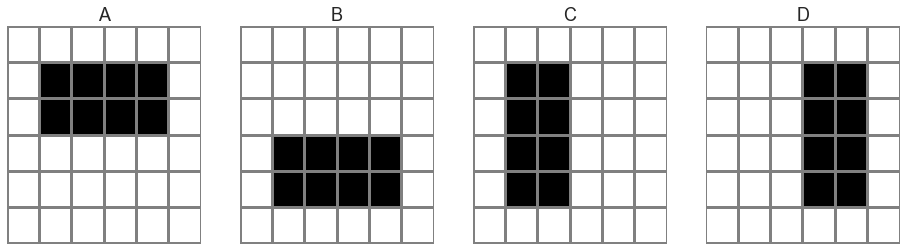

In [4]:
plot_problem(example_problem)

## Evaluate examples literally

Helper: Plot examples

In [5]:
true_concept = np.array(squareC)
example_mask = np.array([
    [1,1,1,1,1,1],
    [1,0,1,1,1,1],
    [1,1,0,1,1,1],
    [1,1,0,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
]).astype(np.bool)

example = np.ma.masked_array(true_concept, mask=example_mask).astype(np.float)

def plot_example(ex):
    example_view = ex.filled(0.5)
    ax = sns.heatmap(example_view, vmin=0, vmax=1, 
                     cmap='gray_r', cbar=False, square = True,
                     linewidths=1, linecolor='#808080')
    ax.set(xticks=[],yticks=[])

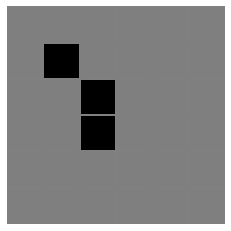

In [6]:
plot_example(example)

All possible combinations of examples:

In [7]:
n = 36
ex_1 = [[i] for i in  range(n)]
ex_2 = [[i,j] for i in range(n) for j in range(i+1,n)]
ex_3 = [[i,j,k] for i in range(n) for j in range(i+1,n) for k in range(j+1,n)]

print('Singles: %i' % len(ex_1))
print('Doubles: %i' % len(ex_2))
print('Triples: %i' % len(ex_3))

Singles: 36
Doubles: 630
Triples: 7140


Check if a list of indices fully disambiguates a concept:

In [8]:
def idx_to_mask(idx):
    ex = np.zeros(36)
    ex[idx] = 1
    ex = np.reshape(ex, (6,6))
    ex = ex.astype(np.bool)
    
    return ex

def disambiguates(idx, target, problem):
    mask = idx_to_mask(idx)
    true_h = problem[target,:,:]
    
    any_matches = False
    for i in range(problem.shape[0]):
        if i != target:
            distractor_h = problem[i,:,:]
            any_matches = np.array_equal(true_h[mask], distractor_h[mask])
            if any_matches:
                break
                
    return not any_matches

How many examples do you need to disambiguate the concept?

In [9]:
all_examples = ex_1+ex_2+ex_3
def minimum_all(target, problem, example_space=all_examples):
    n = np.nan
    ex_mask = np.empty((6,6))
    for ex in example_space:
        if disambiguates(ex, target, problem):
            ex_mask = idx_to_mask(ex)
            n = len(ex)
            break
            
    return n, ex_mask

In [10]:
for i in range(4):
    n, _ = minimum_all(i, example_problem)
    print(n)

2
2
2
2


**new:** Disambiguating using only positive examples

In [11]:
def positive_indices(concept):
    pos_coords = np.nonzero(concept)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6))
    pos_idx = list(pos_idx)
    n_idx = len(pos_idx)

    indices = []

    for i in range(n_idx):
        indices.append([pos_idx[i]])
        for j in range(i+1, n_idx):
            indices.append([pos_idx[i],pos_idx[j]])
            for k in range(j+1, n_idx):
                indices.append([pos_idx[i],pos_idx[j],pos_idx[k]])
                
    indices = sorted(indices, key=len)
    return indices

def minimum_positive(target, problem):
    pos_examples = positive_indices(problem[target,:,:])
    n, ex_mask = minimum_all(target, problem, pos_examples)
    return n, ex_mask